In [1]:
%run ../__init__.py

In [2]:
%matplotlib inline

In [3]:
budget = pd.read_csv('../data/school_budget_train.csv')

In [4]:
budget_df = pd.DataFrame(budget)

In [5]:
budget_df.columns = ['ID' if x=='Unnamed: 0' else x for x in budget_df.columns]

In [6]:
budget_df.shape

(400277, 26)

In [7]:
budget_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400277 entries, 0 to 400276
Data columns (total 26 columns):
ID                        400277 non-null int64
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    179964 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE        

In [8]:
budget_df = budget_df.drop('ID', axis=1)

In [9]:
targets = ['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type',
       'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status']

In [10]:
predictors = [col for col in budget_df.columns if col not in targets]
word_predictors = ['Object_Description','Text_2','SubFund_Description','Job_Title_Description','Text_3','Text_4',
                   'Sub_Object_Description','Location_Description','Function_Description','Facility_or_Department','Position_Extra',
                   'Program_Description','Fund_Description','Text_1']

num_predictors = ['FTE', 'Total']

### Change label columns, append category names to labels

In [11]:
for col in budget_df[targets]:
    budget_df[col] = str(col)+'__'+ budget_df[col].astype(str)

In [12]:
budget_df[targets].head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status
0,Function__Teacher Compensation,Use__Instruction,Sharing__School Reported,Reporting__School,Student_Type__NO_LABEL,Position_Type__Teacher,Object_Type__NO_LABEL,Pre_K__NO_LABEL,Operating_Status__PreK-12 Operating
1,Function__NO_LABEL,Use__NO_LABEL,Sharing__NO_LABEL,Reporting__NO_LABEL,Student_Type__NO_LABEL,Position_Type__NO_LABEL,Object_Type__NO_LABEL,Pre_K__NO_LABEL,Operating_Status__Non-Operating
2,Function__Teacher Compensation,Use__Instruction,Sharing__School Reported,Reporting__School,Student_Type__Unspecified,Position_Type__Teacher,Object_Type__Base Salary/Compensation,Pre_K__Non PreK,Operating_Status__PreK-12 Operating
3,Function__Substitute Compensation,Use__Instruction,Sharing__School Reported,Reporting__School,Student_Type__Unspecified,Position_Type__Substitute,Object_Type__Benefits,Pre_K__NO_LABEL,Operating_Status__PreK-12 Operating
4,Function__Substitute Compensation,Use__Instruction,Sharing__School Reported,Reporting__School,Student_Type__Unspecified,Position_Type__Teacher,Object_Type__Substitute Compensation,Pre_K__NO_LABEL,Operating_Status__PreK-12 Operating


In [13]:
categorize_label = lambda x: x.astype('category')
budget_df[targets] = budget_df[targets].apply(categorize_label, axis=0)

### Find NaN and fill NaN values for text columns with empty strings

In [14]:
budget_df[targets].isnull().sum().sort_values()

Function            0
Use                 0
Sharing             0
Reporting           0
Student_Type        0
Position_Type       0
Object_Type         0
Pre_K               0
Operating_Status    0
dtype: int64

In [15]:
budget_df[predictors].isnull().sum().sort_values()

Total                       4555
Object_Description         24784
Function_Description       58082
SubFund_Description        93422
Program_Description        95617
Job_Title_Description     107534
Text_1                    107992
Position_Extra            135513
Fund_Description          197400
Text_3                    220313
Location_Description      238223
FTE                       274206
Sub_Object_Description    308674
Text_2                    312060
Facility_or_Department    346391
Text_4                    346531
dtype: int64

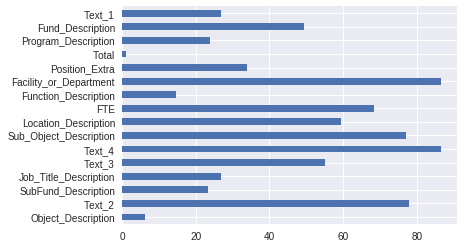

In [16]:
_ = (budget_df[predictors].isnull().sum()/budget_df[predictors].shape[0]*100).plot(kind='barh')

In [17]:
for col in budget_df[word_predictors]:
    budget_df[col] = budget_df[word_predictors].loc[:,[col]].fillna(' ')

In [18]:
budget_df[predictors].isnull().sum()

Object_Description             0
Text_2                         0
SubFund_Description            0
Job_Title_Description          0
Text_3                         0
Text_4                         0
Sub_Object_Description         0
Location_Description           0
FTE                       274206
Function_Description           0
Facility_or_Department         0
Position_Extra                 0
Total                       4555
Program_Description            0
Fund_Description               0
Text_1                         0
dtype: int64

In [19]:
budget_df.describe()

,FTE,Total
count,126071.000000,3.957220e+05
mean,0.426794,1.310586e+04
std,0.573576,3.682254e+05
min,-0.087551,-8.746631e+07
25%,0.000792,7.379770e+01
50%,0.130927,4.612300e+02
75%,1.000000,3.652662e+03
max,46.800000,1.297000e+08


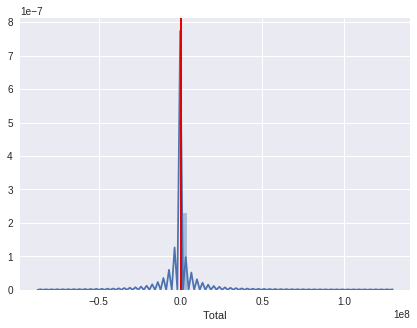

In [20]:
plt.figure(1, figsize=(7,5))
_ = sns.distplot(budget_df['Total'].dropna())
plt.axvline(budget_df['Total'].median(), c='black')
plt.axvline(budget_df['Total'].mean(), c='red')

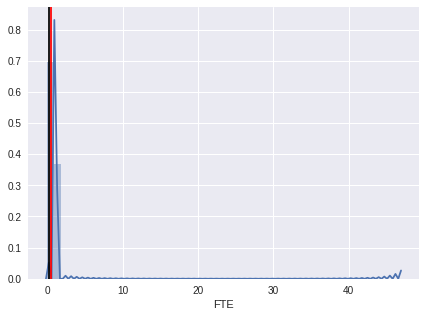

In [21]:
plt.figure(1, figsize=(7,5))
_ = sns.distplot(budget_df['FTE'].dropna())
plt.axvline(budget_df['FTE'].median(), c='black')
plt.axvline(budget_df['FTE'].mean(), c='red')

In [22]:
mask_fte = (budget_df['FTE'] > 1) | (budget_df['FTE'] < 0)
print(mask_fte.sum())

3119


In [23]:
# all values less than 0 becomes 0 and values greater than 1 becomes 1
# values greater than 1 and less than 1 were incorrect and skewing the the mean, so clipped them
budget_df['FTE'] = np.clip(budget_df['FTE'],0,1)

## Impute values for numerical columns

Fill 'Total' column with mean value since graph shows that values are normally distributed where mean and median are the same

In [24]:
from sklearn.preprocessing import Imputer

In [25]:
imputer = Imputer()
budget_df[num_predictors]=imputer.fit_transform(budget_df[num_predictors])

## Data cleaning for word predictor columns

In [1]:
import re
from spacy.en import English
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords
from spacy.en import STOP_WORDS
nlp = English()

In [26]:
for col in budget_df[word_predictors]:
    budget_df[col] = budget_df[col].str.lower()

In [29]:
for col in budget_df[word_predictors]:
    budget_df[col] = budget_df[col].replace({"n/a": 'na'})

In [28]:
def cleaner(text):
    text = re.sub('[^a-zA-Z0-9]',' ',text)
    text = re.sub("\\s+", " ", text)
    text = ' '.join(i.lemma_ for i in nlp(text)
                    if i.orth_ not in STOP_WORDS)
    return text

In [30]:
for col in budget_df[word_predictors]:
    budget_df[col] = budget_df[col].apply(cleaner)
    print(col)

Object_Description
Text_2
SubFund_Description
Job_Title_Description
Text_3
Text_4
Sub_Object_Description
Location_Description
Function_Description
Facility_or_Department
Position_Extra
Program_Description
Fund_Description
Text_1


In [31]:
unique_values = []
for col in budget_df[word_predictors]:
    unique_vals = budget_df[col].nunique()
    unique_values.append({'column_name': col,
                        'unique_vals': unique_vals})

In [32]:
pd.DataFrame(unique_values)

,column_name,unique_vals
0,Object_Description,537
1,Text_2,277
2,SubFund_Description,266
3,Job_Title_Description,3127
4,Text_3,36
5,Text_4,236
6,Sub_Object_Description,161
7,Location_Description,343
8,Function_Description,627
9,Facility_or_Department,173


In [33]:
budget_df['combined_text'] = budget_df[word_predictors].apply(lambda x: " ".join(x), axis=1)

In [34]:
def value_counts(col):
    counts = budget_df[col].value_counts()
    percent = budget_df[col].value_counts(normalize=True)
    return pd.DataFrame({'counts': counts, 
                         'percent': percent})

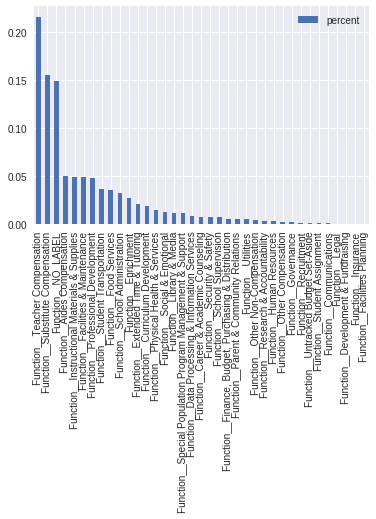

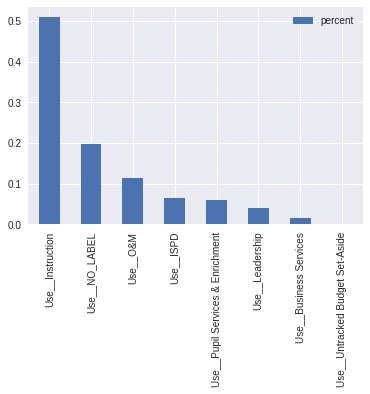

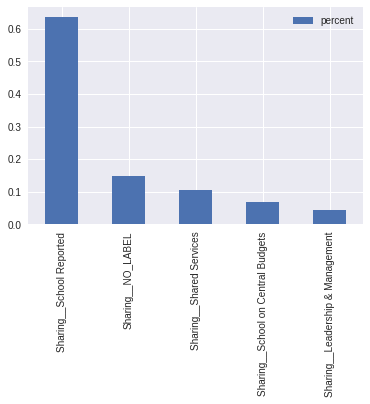

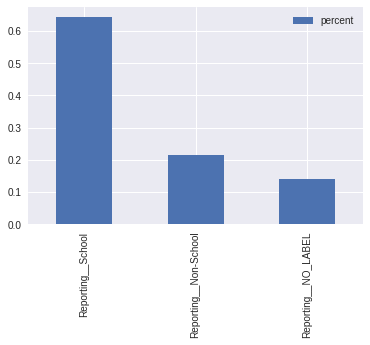

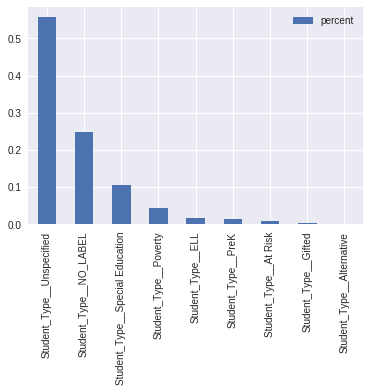

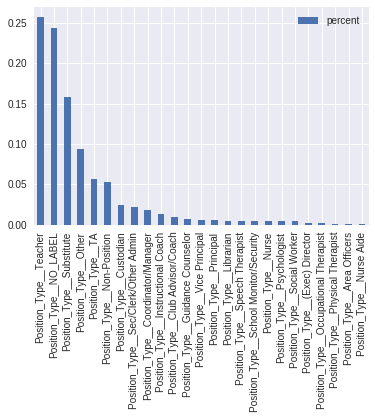

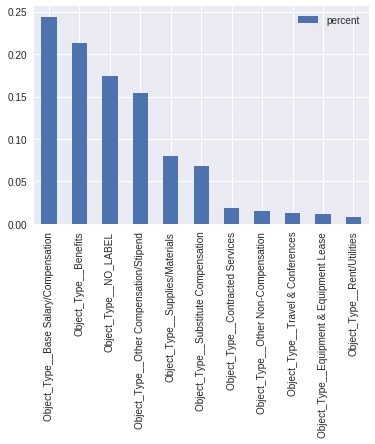

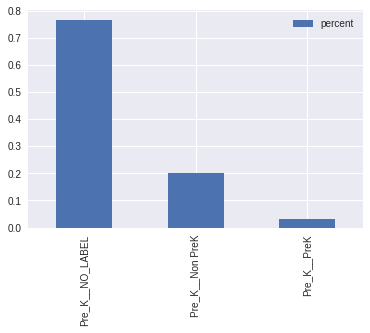

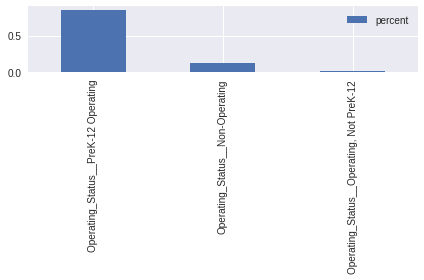

In [37]:
for i, col in enumerate(budget_df[targets]):
    col = value_counts(col)
    col[['percent']].plot.bar()
    
plt.tight_layout()

In [35]:
budget_df.to_csv('../data/budget_df_cleaned1.csv')

In [36]:
budget_df[word_predictors].head()

,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,Function_Description,Facility_or_Department,Position_Extra,Program_Description,Fund_Description,Text_1
0,,,,teacher elementary,,,,,,,kindergarten,kindergarten,general fund,
1,contractor service,bond expenditure,building fund,blank,regular,,,,rgn gob,,undesignated,building improvement service,,building improvement service
2,personal service teacher,,,tcher 2nd grade,,regular instruction,,,,,teacher,instruction regular,general purpose school,
3,employee benefit,teacher sub,general fund,teacher short term sub,regular,,,,unalloc budget school,,professional instructional,general middle junior high sch,,regular instruction
4,teacher coverage teacher,teacher sub,general fund,teacher secondary high,alternative,,,,non project,,professional instructional,general high school education,,regular instruction
